In [2]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
from scipy.stats import skew, kurtosis, pearsonr

In [3]:
import pandas as pd

In [4]:
from Dataset import get_data
from preprocessing import shuffle_dataset, text_processing

In [5]:
#Dataset Generation
data=get_data('training')
test_data=get_data('test-gold')

In [6]:
len(data), len(test_data)

(7102, 4068)

In [7]:
data=shuffle_dataset(data)
test_data=shuffle_dataset(test_data)

In [8]:
data['Tweet']=data['Tweet'].apply(text_processing)
test_data['Tweet']= test_data['Tweet'].apply(text_processing)

In [9]:
emotions=data['Affect Dimension'].unique().tolist()
def label_encoding(emotion):
    return emotions.index(emotion)

data['label']=data['Affect Dimension'].apply(label_encoding)
test_data['label']= test_data['Affect Dimension'].apply(label_encoding)

### Few explorations like correlations, Making cluster of the training labels

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer


In [11]:
tf_idf=TfidfVectorizer()
X=tf_idf.fit_transform(data['Tweet'])

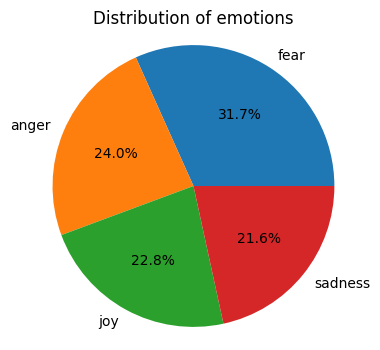

In [12]:
###Distribution of tweets
label_count=data['Affect Dimension'].value_counts()
plt.figure(figsize=(4,4))
plt.pie(label_count,labels=label_count.index, autopct='%1.1f%%')
plt.title('Distribution of emotions')
plt.axis('equal')
plt.savefig("data.png")
plt.show()

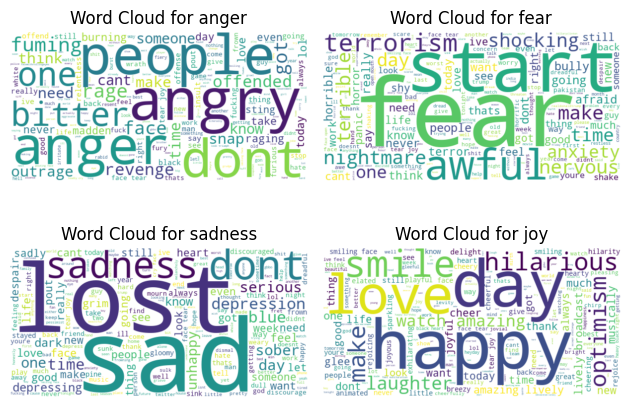

In [13]:
#### Finding the mostly commom words for each emotion
fig,ax=plt.subplots(2,2)
for ax,label in zip(ax.flatten(),data['Affect Dimension'].unique()):
    temp=data[data['Affect Dimension']==label]
    text=' '.join(temp['Tweet'])
    cloud=WordCloud(width=600, height=300, background_color='white').generate(text)
    ax.imshow(cloud, interpolation='bilinear')
    ax.set_title('Word Cloud for '+ label)
    ax.axis('off')
    
plt.tight_layout()
plt.savefig('wordcloud.png')
plt.show()


##### There are presence of same words in different tweets that can be troublesome for performing lexicon analysis

In [14]:
###
def num_words(sentence):
    return len(sentence.split())
data['total_words']=data['Tweet'].apply(num_words)

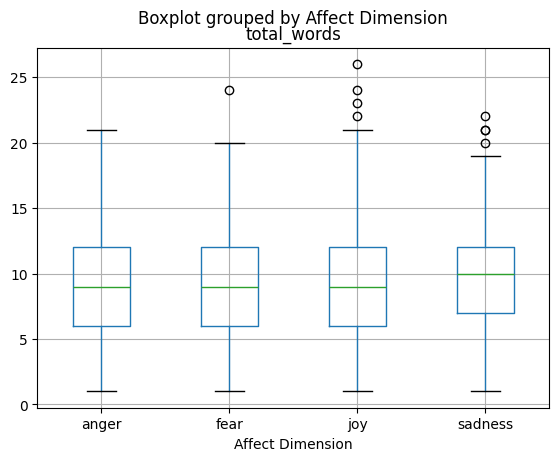

In [15]:
data.boxplot(by='Affect Dimension', column='total_words')
plt.grid('off')
plt.savefig('box_words.png')
plt.show()

##### Tweets for each emotions has average words 9,  All the emotions have words in between 6 to 13.  There are few outliers in the fear, joy and sadness.

anger -  {'Skew': 0.030819610464149775, 'kurtosis': 2.4423135696065867}
fear -  {'Skew': -0.058402658496586206, 'kurtosis': 2.4277961437259687}
sadness -  {'Skew': 0.020442304789742696, 'kurtosis': 2.5375208676619505}
joy -  {'Skew': 0.3157297698957461, 'kurtosis': 3.1549388937774494}


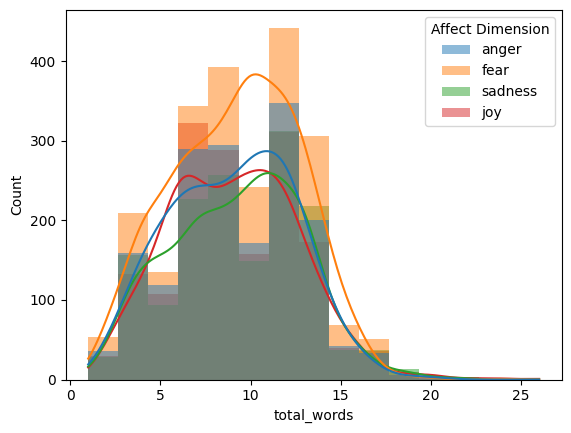

In [16]:
sns.histplot(data=data, x='total_words', hue='Affect Dimension', edgecolor=None, bins=15, kde=True)
plt.savefig('skew.png')
for label in data['Affect Dimension'].unique():
    res={}
    res['Skew']= skew(data[data['Affect Dimension']== label].total_words)
    res['kurtosis']=kurtosis(data[data['Affect Dimension']==label].total_words, fisher=False)
    print(label, "- ",res)

##### only Fear's distribution is left skewed, rest are right skewed. The peaks are following normal distribution

In [17]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer

In [18]:

vectorizer=TfidfVectorizer()
tf_matrix=vectorizer.fit_transform(data['Tweet'])


In [19]:
kmeans=KMeans(n_clusters=4, random_state=2)
clusters=kmeans.fit_predict(tf_matrix)

In [20]:
pca=PCA(n_components=2)
tf_pca=pca.fit_transform(tf_matrix.toarray())

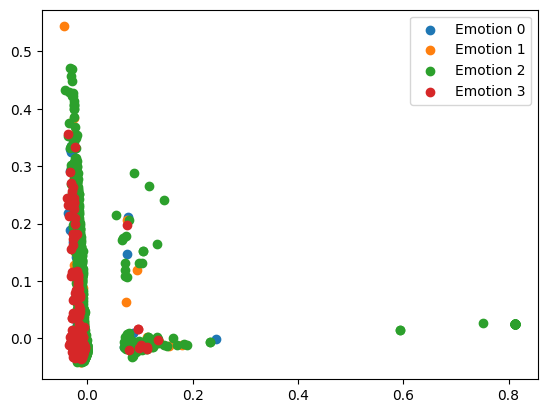

In [21]:

for i in range(4):
    plt.scatter(tf_pca[clusters==i,0], tf_pca[clusters==i, 1],label='Emotion '+str(i))
plt.legend()

##### Datapoints are ovelapping due to the presence of similar words in tweets

In [22]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
#from nltk.stem import WordNetLemmatizer

def get_sentiment_vedar(text):
    analyzer=SentimentIntensityAnalyzer()
    scores=analyzer.polarity_scores(text)
    
    return scores

In [23]:
data['valence_score']=data['Tweet'].apply(lambda x: get_sentiment_vedar(x)['compound'])

In [24]:
corr, p_val=pearsonr(data['valence_score'], data['label'])

In [25]:
corr, p_val

(0.41367645481512877, 9.760340631899404e-292)

###### Analysis of variance ANOVA

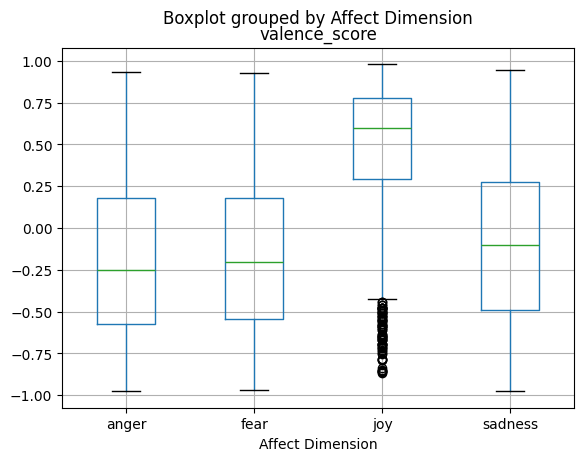

In [26]:
data.boxplot(by='Affect Dimension', column='valence_score')
plt.grid('off')
plt.savefig('valence.png')
plt.show()

#### Seems like variables are weakly  correlated.  since there are difference between mean value

In [27]:
# x=data.label.to_list()
# y=np.array(data.valence_score.tolist())
# plt.scatter(x,y, c=np.where(y < 0,'red', 'green'))

In [28]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers_interpret import MultiLabelClassificationExplainer

In [ ]:
##Source: https://github.com/cdpierse/transformers-interpret
model_name='j-hartmann/emotion-english-distilroberta-base'
model=AutoModelForSequenceClassification.from_pretrained(model_name)

tokenizer=AutoTokenizer.from_pretrained(model_name)

cls_explainer=MultiLabelClassificationExplainer(model, tokenizer)

word_attributions=cls_explainer(data.iloc[5]['Tweet'])

In [30]:
print(cls_explainer.visualize('multilabel_viz.html'))

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
n/a,(0.35),anger,0.05,#s branded by cas like started college horrific probably get better dont give yet #/s
n/a,(0.32),disgust,0.13,#s branded by cas like started college horrific probably get better dont give yet #/s
n/a,(0.99),fear,0.69,#s branded by cas like started college horrific probably get better dont give yet #/s
n/a,(0.10),joy,-0.64,#s branded by cas like started college horrific probably get better dont give yet #/s
n/a,(0.40),neutral,-0.41,#s branded by cas like started college horrific probably get better dont give yet #/s
n/a,(0.50),sadness,0.05,#s branded by cas like started college horrific probably get better dont give yet #/s
n/a,(0.27),surprise,-0.56,#s branded by cas like started college horrific probably get better dont give yet #/s


<IPython.core.display.HTML object>


In [31]:
data.iloc[5]['Tweet'], data.iloc[5]['Affect Dimension']

('brandedbycas like started college horrific probably get better dont give yet',
 'fear')


##### Classification of sentiments


In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier

In [33]:
tf_vector=TfidfVectorizer()
tf_vector.fit(data['Tweet'].tolist()+test_data['Tweet'].tolist())
x_train=tf_vector.transform(data['Tweet'].tolist())
x_test=tf_vector.transform(test_data['Tweet'].tolist())
y_train=data['label'].tolist()
y_test=test_data['label'].tolist()

In [34]:
classfier=RandomForestClassifier(n_estimators=400, max_depth=40 ,random_state=1)
classfier.fit(x_train,y_train)

RandomForestClassifier(max_depth=40, n_estimators=400, random_state=1)

In [35]:
from sklearn.metrics import accuracy_score, classification_report

In [36]:
predictions=classfier.predict(x_test)
print("Accuracy : "+str(accuracy_score(y_test,predictions)))

Accuracy : 0.5191740412979351


In [37]:
#### Hyperparameters tuning to get better accuracy
from sklearn.model_selection import GridSearchCV

params={
    'n_estimators':[200,300,400,500],
    'max_depth':[20,25,30,35,40]
}
grid_search=GridSearchCV(estimator=classfier, param_grid=params, cv=5)
grid_search.fit(x_train,y_train)

print("Best Parameters ")
print(grid_search.best_params_, grid_search.best_score_)

Best Parameters 
{'max_depth': 40, 'n_estimators': 500} 0.7910418174069045


In [38]:
scores=grid_search.cv_results_['mean_test_score']
parameters=grid_search.cv_results_['params']
params_list=[]
for p in parameters:
    params_list.append((p['max_depth'], p['n_estimators']))
    

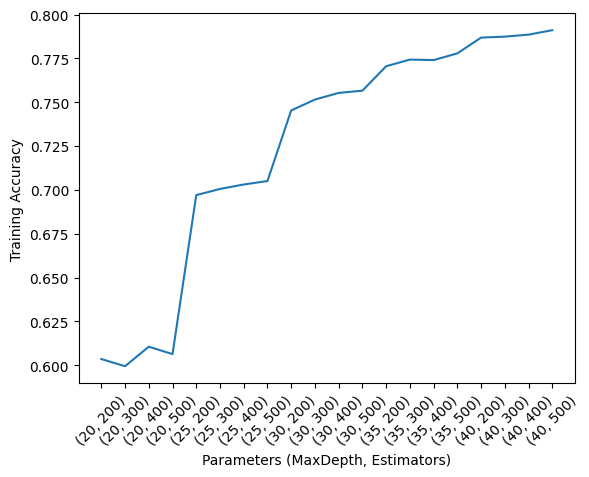

In [39]:
plt.plot(range(len(scores)),scores)
plt.xlabel('Parameters (MaxDepth, Estimators)')
plt.ylabel('Training Accuracy')
plt.xticks(range(len(scores)),params_list, rotation=45)
plt.savefig('gs.png')
plt.show()

##### Other mdoels to compare

In [40]:
models_hist={}

In [41]:
#### Adding RandomForestClassifier
predictions=classfier.predict(x_train)
res1=accuracy_score(y_train,predictions)
predictions=classfier.predict(x_test)
res2=accuracy_score(y_test,predictions)
models_hist['RandomForestClassifier']={'train ':res1, 'Test': res2}

##### Naive Bayes

In [42]:

from sklearn.naive_bayes import MultinomialNB


In [43]:
naive=MultinomialNB()
naive.fit(x_train,y_train)
train_acc=naive.predict(x_train)
res1=accuracy_score(y_train,train_acc)
print("Train Accuracy : "+str(res1))
predictions=naive.predict(x_test)
res2=accuracy_score(y_test,predictions)
print("Test Accuracy : "+str(res2))
models_hist['Naive_Bayes']={'train ':res1, 'Test': res2}


Train Accuracy : 0.9402985074626866
Test Accuracy : 0.5007374631268436


#### Support Vector Machine

In [44]:
from sklearn.svm import SVC

In [45]:
svm=SVC()
svm.fit(x_train,y_train)
train_acc=svm.predict(x_train)
res1=accuracy_score(y_train,train_acc)
print("Train Accuracy : "+str(res1))
predictions=svm.predict(x_test)
res2=accuracy_score(y_test,predictions)
print("Test Accuracy : "+str(res2))
models_hist['SVM']={'train ':res1, 'Test': res2}


Train Accuracy : 0.9719797240214024
Test Accuracy : 0.5530973451327433


#### Gradient Boosting 

In [46]:
from sklearn.ensemble import GradientBoostingClassifier

In [47]:
gb=GradientBoostingClassifier(n_estimators=400, random_state=2)
gb.fit(x_train,y_train)
train_acc=gb.predict(x_train)
res1=accuracy_score(y_train,train_acc)
print("Train Accuracy : "+str(res1))
predictions=gb.predict(x_test)
res2=accuracy_score(y_test,predictions)
print("Test Accuracy : "+str(res2))
models_hist['Gradient_Boost']={'train ':res1, 'Test': res2}

Train Accuracy : 0.9056603773584906
Test Accuracy : 0.5577679449360865


In [48]:
models_hist

{'RandomForestClassifier': {'train ': 0.860321036327795,
  'Test': 0.5191740412979351},
 'Naive_Bayes': {'train ': 0.9402985074626866, 'Test': 0.5007374631268436},
 'SVM': {'train ': 0.9719797240214024, 'Test': 0.5530973451327433},
 'Gradient_Boost': {'train ': 0.9056603773584906, 'Test': 0.5577679449360865}}

In [49]:
#### Model Comparison

In [50]:
models=list(models_hist.keys())
train_sc=[models_hist[model]['train '] for model in models]
test_sc=[models_hist[model]['Test'] for model in models]

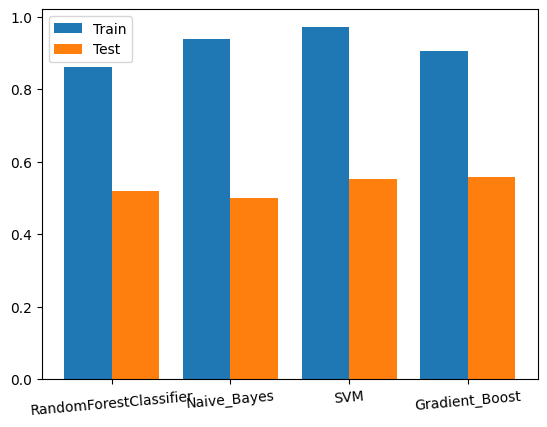

In [51]:
n=range(len(models))
fig,ax=plt.subplots()
train_boxs=ax.bar(n,train_sc, 0.40, label='Train')
test_boxs=ax.bar([x+0.40 for x in n],test_sc, 0.40, label='Test')
ticks=[r+0.20 for r in n]
plt.xticks(ticks, models, rotation=5)
plt.legend()
plt.savefig('model_comp.png')
plt.show()